Falling back to non-multisampled frame buffer
Falling back to num_samples=8
Falling back to non-multisampled frame buffer
Using object: Ball_1
Falling back to non-multisampled frame buffer
Falling back to num_samples=8
Falling back to non-multisampled frame buffer


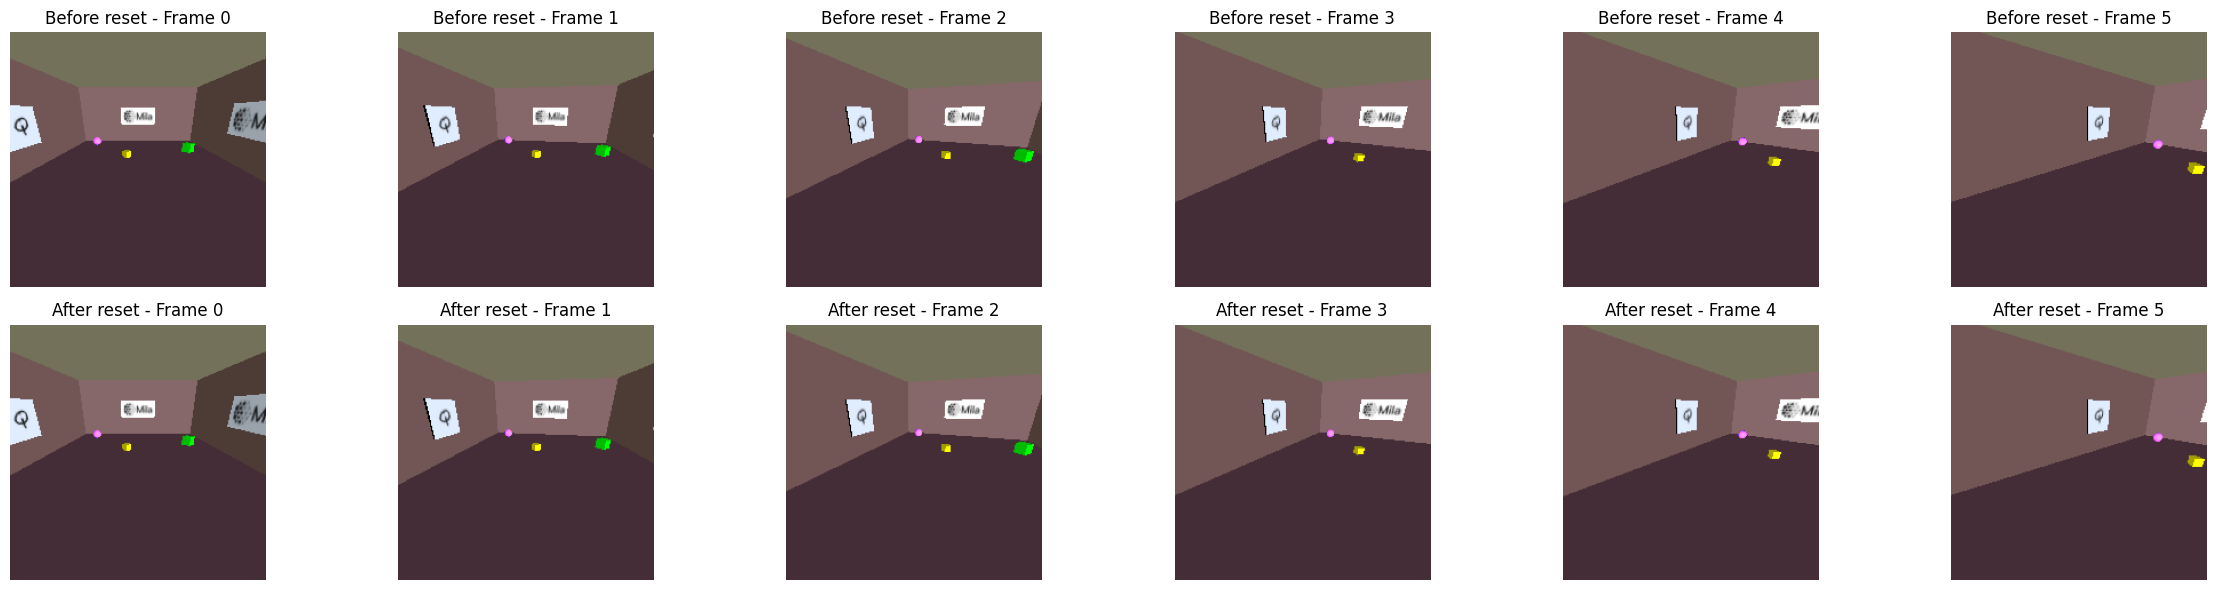

In [2]:
# 🛠️ Setup
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from gymnasium.envs.registration import register

from miniworld.envs.jeparoom import RearrangeOneRoom
from policies.rearrange import HumanLikeRearrangePolicy


# 🔁 Register the environment (same logic as your main script)
def _register_environment(env_id: str, seed: int) -> None:
    register(
        id=env_id,
        entry_point=RearrangeOneRoom,
        kwargs={"size": 12, "seed": seed},
        max_episode_steps=250,
    )


# 🧪 Run policy and collect images
def run_policy(env_id: str, seed: int, object_id: str = None):
    env = gym.make(
        env_id,
        seed=seed,
        max_entities=4,
        obs_width=224,
        obs_height=224,
        domain_rand=True,
        render_mode="rgb_array",
    )
    
    policy = HumanLikeRearrangePolicy(env=env, seed=seed, target=[object_id] if object_id else [])
    policy.rearrange()

    obs = np.asarray(policy.observations, dtype=np.uint8)
    env.close()
    return obs


# ✅ Set seed and register environment
SEED = 1234
ENV_ID = "RearrangeOneRoom-v0"
_register_environment(ENV_ID, SEED)

# 🔍 Discover one valid object to target
env_probe = gym.make(
    ENV_ID,
    seed=SEED,
    max_entities=4,
    obs_width=224,
    obs_height=224,
    domain_rand=True,
    render_mode="rgb_array",
)
probe_policy = HumanLikeRearrangePolicy(env=env_probe, seed=SEED, target=[])
object_nodes = [
    nid for nid in probe_policy.node_pos2d
    if any(str(nid).startswith(pref) for pref in ("Box", "Ball", "Key"))
]
env_probe.close()

# 📸 Run expert policy before reset
print(f"Using object: {object_nodes[0]}")
# ✅ Create env once
env = gym.make(
    ENV_ID,
    seed=SEED,
    max_entities=4,
    obs_width=224,
    obs_height=224,
    domain_rand=True,
    render_mode="rgb_array",
)

# ✅ First rollout
policy = HumanLikeRearrangePolicy(env=env, seed=SEED, target=[object_nodes[0]])
env.reset(seed=SEED)
policy.rearrange()
images_before = np.asarray(policy.observations, dtype=np.uint8)

# ✅ Reset and rerun
env.reset(seed=SEED)
policy = HumanLikeRearrangePolicy(env=env, seed=SEED, target=[object_nodes[0]])
policy.rearrange()
images_after = np.asarray(policy.observations, dtype=np.uint8)

env.close()



# 🖼️ Compare the first few frames
N = min(len(images_before), len(images_after), 6)  # only show first 6
fig, axs = plt.subplots(2, N, figsize=(4 * N, 6))

for i in range(N):
    axs[0, i].imshow(images_before[i])
    axs[0, i].set_title(f"Before reset - Frame {i}")
    axs[0, i].axis("off")

    axs[1, i].imshow(images_after[i])
    axs[1, i].set_title(f"After reset - Frame {i}")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()
